In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [58]:
print("VERSÕES")
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Scikit-learn: {sklearn.__version__}')
print(f'XGBoost: {xgboost.__version__}')

VERSÕES
Numpy: 2.3.5
Pandas: 2.3.3
Matplotlib: 3.10.6
Scikit-learn: 1.7.2
XGBoost: 3.1.2


In [59]:
# Seed Fixo para execução dos modelos
SEED = 43
np.random.seed(SEED)

In [60]:
def generate_poisson_data(n_samples=1000, complexity='simple'):
    x = np.linspace(0, 2, n_samples).reshape(-1, 1)
    if complexity == 'simple':
        y = -((x-1)**7)/7 - ((x-1)**3)/3
    else:
        y = np.sin(np.pi*x)**2
    return x, y.ravel()

# Duas bases de dados
datasets = {
    "Polinomial": generate_poisson_data(complexity='simple'),
    "Oscilatorio": generate_poisson_data(complexity='complex')
}

In [61]:
# Definição dos Modelos e Ensemble
models = [
    ('SVM', SVR(kernel='rbf', C=100, gamma=0.1)),
    ('RF', RandomForestRegressor(n_estimators=100, random_state=SEED)),
    ('XGB', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=SEED))
]
# weights=[1, 2, 2]
ensemble = VotingRegressor(estimators=models, weights=[1, 2, 2])

In [62]:
# Processamento, Métricas e Plotagem
results_summary = []
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)


--- Processando: Polinomial ---
0.004960083430354126
9.868350216762118e-08
2.5388011277741095e-06
0.00019922428938992832

--- Processando: Oscilatorio ---
0.10819994762429391
8.424508402497973e-07
2.4120564732515796e-05
0.00433968797183784

=== TABELA DE MÉTRICAS FINAIS ===
       Dataset              Modelo           MSE     MSE stdev       MAE  \
0   Polinomial                 SVM  4.959891e-03  5.256133e-04  0.063255   
1   Polinomial                  RF  7.333740e-07  2.776495e-07  0.000520   
2   Polinomial                 XGB  5.756622e-06  2.133678e-06  0.001373   
3   Polinomial  Ensemble Ponderado  1.998666e-04  2.066300e-05  0.012681   
4  Oscilatorio                 SVM  1.114187e-01  1.275787e-02  0.278407   
5  Oscilatorio                  RF  6.852028e-06  1.005624e-06  0.002163   
6  Oscilatorio                 XGB  5.751968e-05  1.258333e-05  0.005680   
7  Oscilatorio  Ensemble Ponderado  4.472686e-03  5.195076e-04  0.055846   

   MAE stdev        R2  R2 stdev  
0   

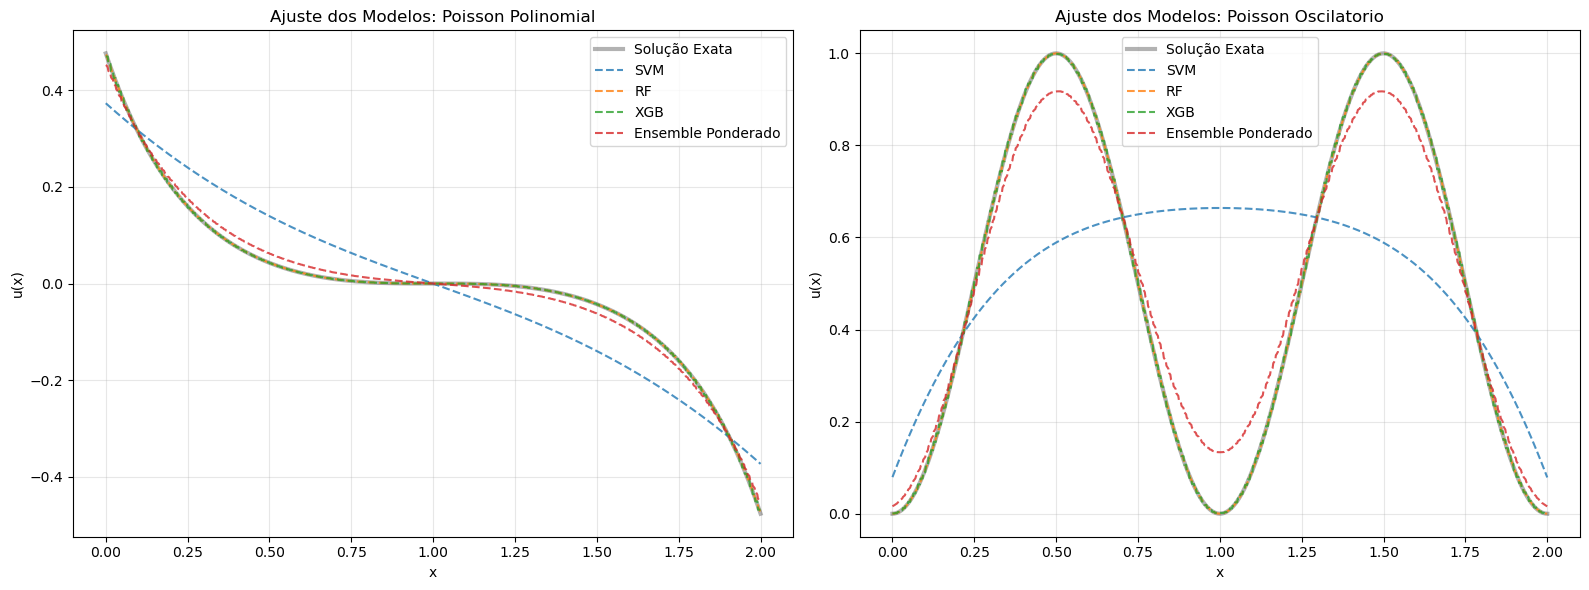

In [ ]:
# Criando a figura para os dois cenários
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (name, (X, y)) in zip(axes, datasets.items()):
    print(f"\n--- Processando: {name} ---")
    
    # Plot da Solução Exata
    ax.plot(X, y, 'k-', lw=3, label='Solução Exata', alpha=0.3)
    
    to_test = models + [('Ensemble Ponderado', ensemble)]
    
    for model_name, model in to_test:
        # A. Validação Cruzada (Calculando MAE, MSE e R2)
        # O prefixo 'neg_' é necessário porque o sklearn trata toda métrica como algo a ser maximizado
        scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
        cv = cross_validate(model, X, y, cv=kf, scoring=scoring)
        
        # B. Guardando as Médias
        results_summary.append({
            'Dataset': name,
            'Modelo': model_name,
            'MSE': -cv['test_neg_mean_squared_error'].mean(),
            'MSE stdev': np.std(-cv['test_neg_mean_squared_error']),
            'MAE': -cv['test_neg_mean_absolute_error'].mean(),
            'MAE stdev': np.std(-cv['test_neg_mean_absolute_error']),
            'R2': cv['test_r2'].mean(),
            'R2 stdev': np.std(cv['test_r2'])
        })

        # Plotagem: Treinamos no conjunto completo para visualizar a curva final
        model.fit(X, y)
        y_pred = model.predict(X)
        
        # Usando as funções importadas para um check rápido no console
        final_mse = mean_squared_error(y, y_pred)
        print(final_mse)
        
        ax.plot(X, y_pred, label=f'{model_name}', linestyle='--', alpha=0.8)

    ax.set_title(f"Ajuste dos Modelos: Poisson {name}")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Exibição da Tabela de Resultados
df_results = pd.DataFrame(results_summary)
print("\n=== TABELA DE MÉTRICAS FINAIS ===")
# print(df_results.sort_values(by=['Dataset', 'MSE']))
print(df_results[['Dataset', 'Modelo', 'MSE', 'MSE stdev', 'MAE', 'MAE stdev', 'R2', 'R2 stdev']])

plt.tight_layout()
plt.savefig('img/classic_plots/results_classic_ponderado.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()